# Przykładowy model predykcyjny na podstawie cosine similarity

## Wczytanie danych

In [1]:
import requests

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

r = requests.get(url, allow_redirects=True)
open('data.zip', 'wb').write(r.content)
!unzip data.zip -d new/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

import pandas as pd

def split_genres(text):
    if text == '(no genres listed)':
        return []

    return text.split("|")

def clean(text):
  new_text = ''
  for x in text:
    if x != '[' and x != ']' and x != ',' and x != "'":
      new_text += x

  return new_text 

def vectorize_tags_and_genres(movies_df, tags_df):
    tags_df.groupby(by='movieId')['tag'].apply(list)
    grouped = tags_df.groupby(by='movieId')['tag'].apply(list).reset_index(name='new')
    movies_tag_merged = movies_df.merge(grouped, how='left', on='movieId')

    movies_tag_merged['genres'] = movies_tag_merged['genres'].apply(split_genres)

    movies_tag_merged['new'] = movies_tag_merged['new'].apply(lambda d: d if isinstance(d, list) else [])

    movies_tag_merged['combined'] = movies_tag_merged['genres'] + movies_tag_merged['new']
    movies_tag_merged['combined'] = movies_tag_merged['combined'].astype('str')
    
    movies_tag_merged['combined'] = movies_tag_merged['combined'].apply(clean)
    
    return movies_tag_merged

def load_movies_ratings_tags_links(dirpath):
  print(dirpath)
  movies = pd.read_csv(dirpath + 'movies.csv',lineterminator='\n')
  ratings = pd.read_csv(dirpath + 'ratings.csv')
  tags = pd.read_csv(dirpath + 'tags.csv')
  links = pd.read_csv(dirpath + 'links.csv')

  return movies, ratings, tags, links

print(os.getcwd())
plt.rcParams["figure.figsize"] = (20,5)
dirpath = ''

movies, ratings, tags, links = load_movies_ratings_tags_links(dirpath)

NameError: name 'X' is not defined

In [3]:
poster_url = "https://image.tmdb.org/t/p/w600_and_h900_bestv2{}"
apikey = "c64ddb28627cb5229e96a8538d22e8f8"
endpoint_url = "https://api.themoviedb.org/3/movie/{}?api_key=c64ddb28627cb5229e96a8538d22e8f8"
cast_endpoint_url = "https://api.themoviedb.org/3/movie/{}/credits?api_key=c64ddb28627cb5229e96a8538d22e8f8"


In [4]:
import requests
from PIL import Image
from io import BytesIO
import base64


def get_poster_base64(tmdbId):
  try:
    response = requests.get(endpoint_url.format(tmdbId))
    path = response.json()['poster_path']
    
    response = requests.get(poster_url.format(path))
    img = Image.open(BytesIO(response.content))
    img.thumbnail((128, 128), Image.LANCZOS)
    return img

  except:
    print(tmdbId)
    return None


def get_poster_for_movie(movieId):
    tmdbId = links[links['movieId'] == movieId]['tmdbId'].iloc[0]

    return get_poster_base64(tmdbId)

In [5]:
import nltk
import string

nltk.download("popular")

def preprocess_tagline(tagline):
  tagline = tagline.lower()

  text_p = "".join([char for char in tagline if char not in string.punctuation])
  
  return text_p

def get_movie_data(tmdbId):
  try:
    response = requests.get(cast_endpoint_url.format(tmdbId))
    cast = response.json()['cast']
    crew = response.json()['crew']
    actors = []
    for actor in cast:
      if actor['popularity'] >= 10:
        actors.append(actor['name'])

    for actor in crew:
      if actor['popularity'] >= 8:
        actors.append(actor['name'])
                      
    response = requests.get(endpoint_url.format(tmdbId))
    tagline = response.json()['overview']

    return (actors, tagline)
  except:
    print(tmdbId)
    return [], ""

def get_data_for_movie(movieId):
    tmdbId = links[links['movieId'] == movieId]['tmdbId'].iloc[0]

    return get_movie_data(tmdbId)

x, d = get_movie_data(550)

' '.join(x) + preprocess_tagline(d)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\SG0311757\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\SG0311757\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\SG0311757\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\SG0311757\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\SG0311757\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_revie

'Edward Norton Brad Pitt Helena Bonham Carter Jared Leto Holt McCallany Eion Bailey David Fincher Mickie McGowana tickingtimebomb insomniac and a slippery soap salesman channel primal male aggression into a shocking new form of therapy their concept catches on with underground fight clubs forming in every town until an eccentric gets in the way and ignites an outofcontrol spiral toward oblivion'

In [32]:
def get_tags_for_movie(movieId):
  return tags[tags['movieId'] == movieId]['tag'].tolist()

  
def get_similars(title, n=10):
  idx = movies[movies['title'] == title].index[0]
  queried_movie = movies.iloc[idx]

  index_score = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(index_score, key=lambda x: x[1], reverse=True)

  top_10 = sim_scores[1:n+1]

  fig, ax = plt.subplots(math.ceil(n/5), 5, layout="compressed", figsize=(10, 8))
  axes = ax.flat

  print(f'Propozycje dla: {queried_movie.title} ({queried_movie.genres}) ({get_tags_for_movie(queried_movie["movieId"])})')

  i = 0
  for (top_idx, similarity) in top_10:
    row_movie = movies.iloc[top_idx]

    similarity = "{:.3f}".format(similarity)
    row_tags = ', '.join(get_tags_for_movie(row_movie['movieId']))

    print(f'{row_movie.title}, cosine_sim: {similarity}')
    print(f'  > Gatunki: {row_movie.genres}')
    print(f'  > Tagi: {row_tags}')
    

    axes[i].imshow(get_poster_for_movie(row_movie['movieId']), aspect='auto')
    i += 1



In [7]:

def pool_data(row):

  cast, tagline = get_data_for_movie(row)

  return ' '.join(cast) + preprocess_tagline(tagline)



In [ ]:
# ["nan","nan","nan","nan","12773.0","17882.0","68149.0","24549.0","14980.0","164721.0","140207.0","192936.0","876.0","149645.0","nan","8677.0","13057.0","2670.0","215993.0","13519.0","152426.0","30983.0","7096.0","110147.0","206216.0","19341.0","36763.0","13716.0","nan","10700.0","nan","58923.0","17266.0","253768.0","49870.0","244797.0","53094.0","118309.0","225130.0","114796.0","13905.0","12224.0","51247.0","9795.0","18884.0","14301.0","67479.0","19422.0","17632.0","61872.0","141714.0","nan","183894.0","110639.0","367647.0","202241.0","58423.0","94174.0","192695.0","26397.0","147269.0","83191.0","193976.0","202043.0","263947.0","215999.0","193380.0","147538.0","69372.0","134481.0","51452.0","253941.0","230657.0","110414.0","178446.0","289394.0","133365.0","202249.0","189197.0","125336.0","278468.0","321640.0","65973.0","62931.0","278604.0","134777.0","27934.0","200813.0","127605.0","72093.0","72095.0","369879.0","370646.0","333040.0","378779.0","192040.0","409696.0","432192.0","331214.0","420714.0","409926.0","419787.0","65595.0","213313.0","406403.0","26787.0","374430.0","461805.0","412103.0","466986.0","463612.0","106035.0","502892.0","500609.0"]

movies['extra_metadata'] = movies['movieId'].apply(pool_data)

nan
nan
nan
nan
12773.0
17882.0
68149.0
24549.0
14980.0
164721.0
140207.0
192936.0
876.0
149645.0
nan
8677.0
13057.0
2670.0
215993.0
13519.0
152426.0
30983.0
7096.0
110147.0
206216.0
19341.0
15370.0
36763.0
11838.0
670.0
25500.0
12583.0
13716.0
6439.0
7214.0
42390.0
43892.0
8422.0
11413.0
29259.0
2436.0
27430.0
34561.0
16638.0
4935.0
8953.0
10951.0
8488.0
32588.0
57825.0
561.0
10214.0
17880.0
8340.0
1942.0
3040.0
43128.0
13498.0
9470.0
19765.0
37527.0
29578.0
2926.0
54302.0
5204.0
8016.0
16186.0
10012.0
76804.0
38148.0
36815.0
31835.0
1093.0
438.0
42222.0
11196.0
13374.0
9688.0
228890.0
10040.0
11638.0
540.0
77120.0
48463.0
26038.0
19884.0
37748.0
22434.0
12778.0
15283.0
158.0
5996.0
44154.0
28448.0
42994.0
17592.0
17113.0
187.0
14177.0
7364.0
11431.0
nan
51945.0
26332.0
42229.0
49565.0
2029.0
44181.0
19971.0
9674.0
3875.0
9653.0
39225.0
4595.0
31442.0
775.0
50183.0
7342.0
45267.0
7453.0
10065.0
30863.0
9393.0
16972.0
13409.0
13073.0
8976.0
27360.0
13020.0
11679.0
1495.0
10066.0
1640.0

In [8]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer


df = vectorize_tags_and_genres(movies, tags)

In [31]:
# df
# df.to_csv(index=False)
import os
os.getcwd()

'/content'

In [32]:
# from google.colab import files
# df.to_csv('output.csv', encoding = 'utf-8-sig')
# files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
compression_opts = dict(method='zip',
                        archive_name='df.csv')  
df.to_csv('df.zip', index=False,
          compression=compression_opts)

In [20]:
# from sklearn.metrics.pairwise import linear_kernel
# from sklearn.feature_extraction.text import TfidfVectorizer


# df = vectorize_tags_and_genres(movies, tags)

# TU se wczytaj plik z csv


df['combined'] = df['extra_metadata'] + df['combined']
vect = TfidfVectorizer(analyzer='word', stop_words='english', min_df = 0, ngram_range = (1, 2))

X = vect.fit_transform(df['combined'])


,Unnamed: 0,movieId,title,genres,extra_metadata,new,combined
0,0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy...",Tom Hanks Tim Allen Wallace Shawn Annie Potts ...,"['pixar', 'pixar', 'fun']",Adventure Animation Children Comedy Fantasy pi...
1,1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']",Robin Williams Kirsten Dunst Bonnie Hunt Jonat...,"['fantasy', 'magic board game', 'Robin William...",Adventure Children Fantasy fantasy magic board...
2,2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']",Ann-Margret Sophia Loren Daryl Hannah Burgess ...,"['moldy', 'old']",Comedy Romance moldy old
3,3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']",Angela Bassett Dennis Haysbert Mykelti William...,[],Comedy Drama Romance
4,4,5,Father of the Bride Part II (1995),['Comedy'],Steve Martin Diane Keaton Martin Short Kimberl...,"['pregnancy', 'remake']",Comedy pregnancy remake
...,...,...,...,...,...,...,...
9746,9738,193583,No Game No Life: Zero (2017),"['Animation', 'Comedy', 'Fantasy']",Ai Kayano Yoshitsugu Matsuokain ancient disboa...,[],Animation Comedy Fantasy
9747,9739,193585,Flint (2017),['Drama'],Queen Latifah Betsy Brandta woman deals with t...,[],Drama
9748,9740,193587,Bungo Stray Dogs: Dead Apple (2018),"['Action', 'Animation']",Akira Ishidaa large scale catastrophe is occur...,None,None
9749,trust and courage are put to the test in orde...,[],Action Animation,None,None,None,None


## Predykcja dla filmu Toy Story z 1995

In [30]:
get_similars('Toy Story (1995)', n=10)

Propozycje dla: Toy Story (1995) (Adventure|Animation|Children|Comedy|Fantasy) (['pixar', 'pixar', 'fun'])
Ride with the Devil (1999), cosine_sim: 0.300
  > Gatunki: Drama|Romance|War
  > Tagi: 
Barking Dogs Never Bite (Flandersui gae) (2000), cosine_sim: 0.250
  > Gatunki: Comedy|Horror
  > Tagi: 
Tampopo (1985), cosine_sim: 0.096
  > Gatunki: Comedy
  > Tagi: 
Tape (2001), cosine_sim: 0.089
  > Gatunki: Drama
  > Tagi: 
Omen, The (2006), cosine_sim: 0.086
  > Gatunki: Horror|Thriller
  > Tagi: 
Magdalene Sisters, The (2002), cosine_sim: 0.081
  > Gatunki: Drama
  > Tagi: religion
Rabbit-Proof Fence (2002), cosine_sim: 0.079
  > Gatunki: Adventure|Drama
  > Tagi: Australia
Miller's Crossing (1990), cosine_sim: 0.076
  > Gatunki: Crime|Drama|Film-Noir|Thriller
  > Tagi: Mafia
Bananas (1971), cosine_sim: 0.072
  > Gatunki: Comedy|War
  > Tagi: 
Klute (1971), cosine_sim: 0.069
  > Gatunki: Drama|Mystery
  > Tagi: 


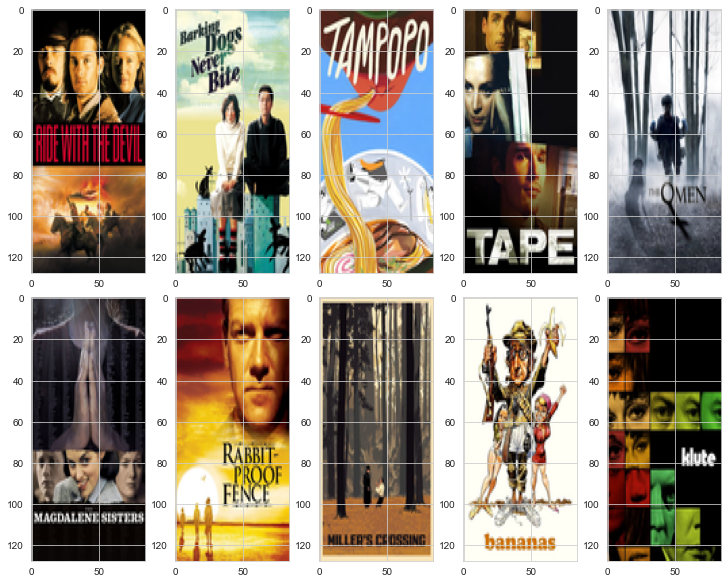

In [33]:
### SVD predyction implementatnion